In [1]:
# import libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
import mesa
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import numpy as np
import math
from matplotlib import rc
import sys
from PIL import Image
import random

np.set_printoptions(threshold=sys.maxsize)

This code runs with mesa version 3.00 or higher

In [2]:
# check mesa version
print("Mesa version: ", mesa.__version__)

Mesa version:  3.0.3


In [3]:
# Function to calculate Euclidean distance (distance between two points)
def euclidean_distance(pos1, pos2):
    # Use the formula to calculate distance between two coordinates
    return math.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)

## Create floor plan for simulation

In [4]:
def image_to_floor_plan(image_path, threshold=128):
    # Load the image
    img = Image.open(image_path)
    
    # Convert to grayscale
    grayscale_img = img.convert("L")  # "L" mode is 8-bit grayscale

    # Convert to numpy array
    img_array = np.array(grayscale_img)
    
    # Binarize the image based on the threshold
    floor_plan = (img_array < threshold).astype(int)  # 1 for obstacles, 0 for walkable
    
    return floor_plan

In [5]:
floor_plan_dir = "./assets/aula_plattegrond_final.png"
floor_plan = image_to_floor_plan(floor_plan_dir)

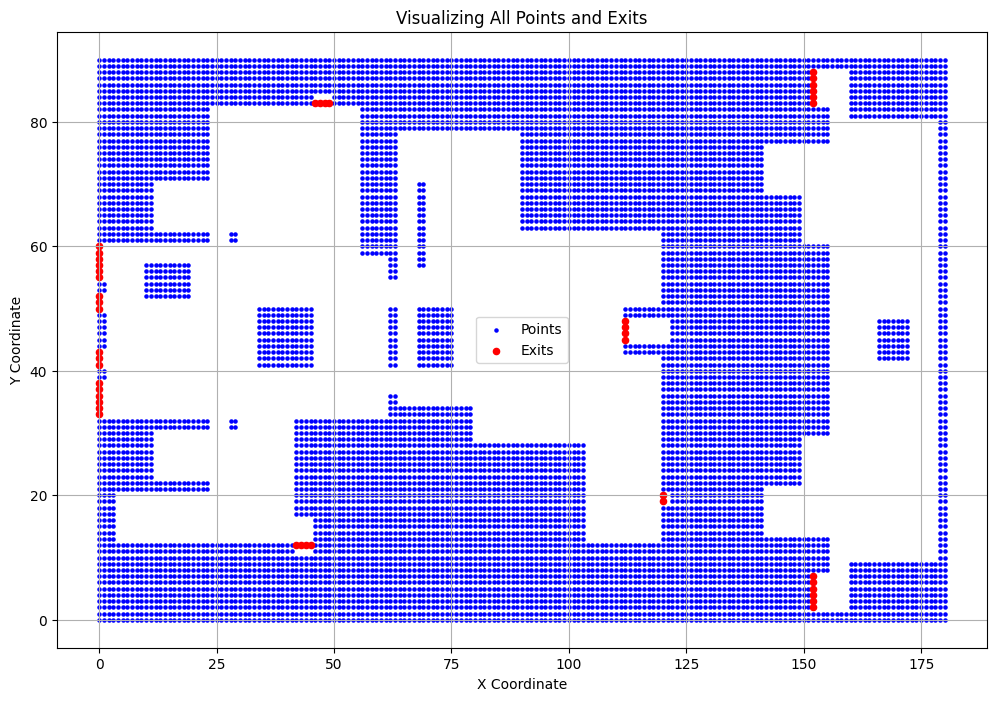

In [6]:
# Prepare data for scatter plot
rows, cols = np.where(floor_plan == 1)
max_y = floor_plan.shape[0] - 1  # For inverting the y-axis
adjusted_rows = [max_y - y for y in rows]

# Extract coordinates for the entire grid
coordinates = list(zip(cols, adjusted_rows))
x_coords = [coord[0] for coord in coordinates]
y_coords = [coord[1] for coord in coordinates]

# Determine exits
exit_locations = [[0, y] for y in range(55, 61)] + [[0, y] for y in range(50, 53)] + [[0, y] for y in range(41, 44)] + [[0, y] for y in range(33, 39)] +[[x, 12] for x in range(42, 46)] + [[x, 83] for x in range(46, 50)] + [[112, y] for y in range(45, 49)] + [[120, y] for y in range(19,21)] + [[152, y] for y in range(2,8)] +[[152, y] for y in range(83, 89)]

exit_x = [coord[0] for coord in exit_locations]
exit_y = [coord[1] for coord in exit_locations]

# Create the scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(x_coords, y_coords, c='blue', s=5, label='Points')  # All points in blue
plt.scatter(exit_x, exit_y, c='red', s=20, label='Exits')  # Exits in red
plt.title("Visualizing All Points and Exits")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.legend()
plt.show()

# Base Model

In [7]:
###################
### AGENT CLASS ###
###################

# Define the NavigationAgent class
class NavigationAgent(Agent):
    def __init__(self, model, vision=5): # Default vision range of 5 cells
        super().__init__(model)  # MESA `Agent` class initialization, auto-assigns unique_id in Mesa 3.0
        # Attributes of each agent
        self.found_exit = False  # Track if agent has reached the exit
        self.previous_pos = None  # Previous position of the agent
        self.vision = vision  # Vision range of the agent
        
    def check_visibility(self, cells_to_check):
        # Return if cells_to_check is empty
        if not cells_to_check:
            return
        
        # Agent's current position
        agent_x, agent_y = self.pos

        # Get all potential cells within the vision radius
        neighborhood_cells = self.model.grid.get_neighborhood(self.pos, moore=True, radius=self.vision, include_center=False)
        
        visible_cells = []  # List to store cells that are visible to the agent

        # Check visibility for each cell in the neighborhood
        for target_x, target_y in neighborhood_cells:
            # Bresenham's Line Algorithm for line-of-sight
            delta_x = abs(target_x - agent_x)
            delta_y = abs(target_y - agent_y)
            step_x = 1 if agent_x < target_x else -1
            step_y = 1 if agent_y < target_y else -1
            error = delta_x - delta_y

            # Start tracing the line from the agent's position
            current_x, current_y = agent_x, agent_y
            is_visible = True  # Assume the cell is visible until proven otherwise

            while (current_x, current_y) != (target_x, target_y):
                # If an obstacle is in the way, mark the cell as not visible
                if (current_x, current_y) in self.model.obstacle_set:
                    is_visible = False
                    break

                # Adjust the error term and move to the next cell along the line
                double_error = 2 * error
                if double_error > -delta_y:
                    error -= delta_y
                    current_x += step_x
                if double_error < delta_x:
                    error += delta_x
                    current_y += step_y

            # If the cell is visible, add it to the visible_cells list
            if is_visible:
                visible_cells.append((target_x, target_y))
        
        visible_cells_set = set(visible_cells)
        intersection = visible_cells_set.intersection(cells_to_check)
        if intersection:
            return list(intersection)

    # Function to move the agent towards the exit
    def move_towards_target(self, target):
        self.previous_pos = self.pos  # Store the current position before moving
        
        # MESA `get_neighborhood` function retrieves nearby cells based on vision range
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        
        min_distance = float('inf')  # Start with a very large distance
        best_step = None  # Initialize best step as None
        
        # Check each possible step to find the one closest to the exit
        for step in possible_steps:
            # Only consider steps that don't have obstacles and have less than 8 agents
            if step not in self.model.obstacle_set and len(self.model.grid.get_cell_list_contents(step)) < 1:
                dist = euclidean_distance(step, target)  # Distance to the exit
                if dist < min_distance:
                    min_distance = dist
                    best_step = step  # Update best step to be closer to the exit
        if best_step:
            # MESA `move_agent` function moves the agent to the new cell
            self.model.grid.move_agent(self, best_step)
    
    def take_stairs(self):
        # Define stair connections as a dictionary
        stair_connections = {"north_GF": self.model.stairs_north_GF,
                            "north_FF": self.model.stairs_north_FF,
                            "south_GF": self.model.stairs_south_GF,
                            "south_FF": self.model.stairs_south_FF}

        # Iterate through the stair connections to find the current position
        for current_stairs, target_stairs in [("north_GF", "north_FF"),("north_FF", "north_GF"),
            ("south_GF", "south_FF"), ("south_FF", "south_GF")]:
            if self.pos in stair_connections[current_stairs]:
                self.model.grid.move_agent(self, random.choice(stair_connections[target_stairs]))
                break  # Exit the loop once a match is found
    
    # Define the actions the agent will take in each step
    def step(self):    
        # Check if the agent is on any stairs and take appropriate action
        if self.pos in self.model.all_stairs:
            self.take_stairs()
    
        vision_area = self.model.grid.get_neighborhood(self.pos, moore=True, radius=self.vision, include_center=False)
        vision_area = list(vision_area)
        
        # Exit simulation if exit is reached
        if self.pos in self.model.exit_locations:
            self.found_exit = True  # Set the agent's exit status to True
            self.model.grid.remove_agent(self)  # MESA function to remove the agent from the grid
            self.remove()  #self.remove() to remove from AgentSet
            self.model.cumulative_exited += 1  # Count this agent in cumulative exited agents
            return True
        
        # Check for exits in unobstructed vision
        #visible_exits = [exit_location for exit_location in self.model.exit_locations if exit_location in vision_area]
        # visible_exits = self.model.exit_locations_set.intersection(vision_area)
        # visible_exits = self.check_visibility(visible_exits)
        # 
        # if visible_exits:
        #     # TODO 2. CHANGE THIS TO SELECTION CRITERIA FOR EXITS
        #     target_exit = random.choice(visible_exits)
        #     self.move_towards_target(target_exit)
        #     return True

class Visitor(NavigationAgent):
    def __init__(self, model, vision=5, drinks=0, friends=[]):
        super().__init__(model, vision=vision)
        
        ##randomm
        
        # 2) Additional attributes for the Visitor subclass
        # Note: random.choices(...) returns a *list*, so we often do [0] to get the first item
        self.follower = random.choices([True, False], weights=[0.9, 0.1])[0]
        self.observer = random.choices([True, False], weights=[0.2, 0.8])[0]
        self.drinks = drinks
        self.friends = friends
        self.my_group = None
        self.drink_timer = random.randint(10, 20)
        self.toilet_timer = None
        self.last_friend_location = None
        self.seen_crew = False
        self.evacuation_exit = None
        self.known_exits = self.model.main_exit

    
    # Function to move the agent randomly if the exit is not in sight
    def move_randomly(self):
        self.previous_pos = self.pos
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        
        # Filter steps to only those without obstacles and with fewer than 8 agents
        valid_steps = [step for step in possible_steps if step not in self.model.obstacle_set and len(self.model.grid.get_cell_list_contents(step)) < 8]
        
        if valid_steps:
            # Randomly choose a valid position and move there
            random_step = self.random.choice(valid_steps)
            # MESA `move_agent` function moves the agent to the chosen position
            self.model.grid.move_agent(self, random_step)
            
    def evacuate_leader(self):
        # Functie waarin er wordt bepaald of je naar de voordeur of de meest dichtbijzijnde deur gaaat. Aan de hand van de locatie en de afstand daarheen.
        vision_area = self.model.grid.get_neighborhood(self.pos, moore=True, radius=self.vision, include_center=False)
        vision_area = list(vision_area)
        
        visible_exits = self.model.exit_locations_set.intersection(vision_area)
        visible_exits = self.check_visibility(visible_exits)
        
        if self.observer == False:
            self.evacuation_exit = random.choice(self.known_exits)
            ## Mochten er later meerdere known exits komen, dan moeten we de code aanpassen
            
        elif visible_exits:  # Als je een exit kan zien, pak die
                distances = {
                exit_pos: euclidean_distance(self.pos, exit_pos) 
                for exit_pos in visible_exits}
            
                min_distance = min(distances.values())
                
                 # Find all exits with the minimum distance
                closest_exits = [exit_pos for exit_pos, dist in distances.items() if dist == min_distance]
            
                # Randomly select one of the closest exits
                self.evacuation_exit = random.choice(closest_exits)
        else: # Als je wel een observer bent, maar je ziet nergens een exit, dan loop je naar de bekende uitgang
            self.evacuation_exit = random.choice(self.known_exits)

        self.move_towards_target(self.evacuation_exit)
                
        return
        
        
        
    def evacuate_follower(self):
        pass
    ## Functie waarin je je vrienden zoekt. Als je er een hebt gevonden, volg je diens gedrag.Na x aantal steps, volg je de meest dichtbijzijnde persoon
    
    def step(self):
        parent_return = super().step()
        
        # Check whether we need to continue function
        if parent_return:
            return 
        
        if self.model.alarm:
            if self.follower:
                self.evacuate_follower()
            else:
                self.evacuate_leader()
            
        # Logic to be executed by followers if an exit is not in range
        if self.follower:
            # Check for leaders in visible area
            vision_area = self.model.grid.get_neighborhood(self.pos, moore=True, radius=self.vision, include_center=False)
            leaders_in_range = [leader for leader in model.grid.get_cell_list_contents(vision_area) if not leader.follower]
            leaders_in_range = self.check_visibility(leaders_in_range)
            
            # If leader found, move towards them
            if leaders_in_range:
                self.move_towards_target(random.choice(leaders_in_range))
            else:
                self.move_randomly()
        else:
            self.move_randomly()
            
class Staff(NavigationAgent):
    def __init__(self, model, vision=5):
        super().__init__(model, vision=vision)
            
                                       


In [10]:
###################
### MODEL CLASS ###
###################

# Define the model class to handle the overall environment
class FloorPlanModel(Model):
    def __init__(self, floor_plan, num_agents, agent_vision, cell_capacity = 1, max_group_size = 5):
        super().__init__()  # `Model` class initialization
        
        # Basic model settings
        self.num_agents = num_agents
        self.agent_vision = agent_vision
        self.grid = MultiGrid(floor_plan.shape[1], floor_plan.shape[0], False)  # MESA grid with dimensions; False means no wrapping
        # self.exit_locations = ([(0, y) for y in range(55, 61)] + [(0, y) for y in range(50, 53)] + [(0, y) for y in range(41, 44)] + 
        #                        [(0, y) for y in range(33, 39)] + [(x, 12) for x in range(42, 46)] + [(x, 83) for x in range(46, 50)] + 
        #                        [(112, y) for y in range(45, 49)] + [(120, y) for y in range(19, 21)] + [(153, y) for y in range(2, 8)] + 
        #                        [(153, y) for y in range(83, 89)])
        # self.exit_locations_set = set(self.exit_locations)
        
        self.main_exit = [(0, y) for y in range(55, 61)] + [(0, y) for y in range(50, 53)] + [(0, y) for y in range(41, 44)] + [(0, y) for y in range(33, 39)]
        self.south_west_exit = [(x, 12) for x in range(42, 46)]
        self.north_west_exit = [(x, 83) for x in range(46, 50)]
        self.east_exit = [(112, y) for y in range(45, 49)]
        self.south_east_exit = [(120, y) for y in range(19, 21)]
        self.first_south_exit = [(153, y) for y in range(2, 8)]
        self.first_north_exit = [(153, y) for y in range(83, 89)]
        
        # Combine all exit locations
        self.exit_locations = (
            self.main_exit + 
            self.south_west_exit + 
            self.north_west_exit + 
            self.east_exit + 
            self.south_east_exit + 
            self.first_south_exit + 
            self.first_north_exit
        )
        
        self.exit_locations_set = set(self.exit_locations)

        self.cell_capacity = cell_capacity # Only one agent per cell by default
        self.max_group_size = max_group_size
        self.alarm = True
        
        self.first_floor_area = {"x_range": (140, 180), "y_range": (0, 90)}
        self.ground_floor_area = {"x_range": (0, 125), "y_range": (10, 85)}
        self.bars_by_floor = {"first_floor": {"x_range": (165, 173), "y_range": (69, 74)}, "ground_floor": {"x_range_1": (28,36), "y_range_1": (17, 22), "x_range_2": (76, 84), "y_range_2": (58, 63)}}
        self.stages_by_floor = {"first_floor": {"x_range": (160, 175), "y_range": (30, 60)}, "ground_floor": {"x_range": (80, 105), "y_range": (35, 55)}}
        
        # Define obstacles, signs and stairs in the grid
        # y-axis needs to be inverted to get the right visualisation
        rows, cols = np.where(floor_plan == 1)        
        max_y = max(rows) 
        adjusted_rows = [max_y - y for y in rows]
        self.obstacles = list(zip(cols, adjusted_rows))
        self.obstacle_set = set(self.obstacles) # Increase efficiency by using a set instead of list
        
        self.signs = []
        self.stairs_north_GF = [(12, y) for y in range(63, 71)]
        self.stairs_south_GF = [(12, y) for y in range(23,31)]
        self.stairs_north_FF = [(142, y) for y in range(69, 77)]
        self.stairs_south_FF = [(142, y) for y in range(14, 22)]
        self.all_stairs = set(self.stairs_north_GF + self.stairs_north_FF + 
                           self.stairs_south_GF + self.stairs_south_FF)
        
        # Initialize cumulative exited count
        self.cumulative_exited = 0

        # Initialize DataCollector (MESA tool for tracking metrics across steps)
        self.datacollector = DataCollector(
            model_reporters={
                "Active Agents": lambda m: len(m.agents),  # Count of agents still active
                "Exited Agents": lambda m: sum(1 for agent in m.agents if isinstance(agent, NavigationAgent) and agent.found_exit),
                "Cumulative Exited Agents": lambda m: m.cumulative_exited,  # Cumulative exited count
                "Agents per Cell": self.count_agents_per_cell  # Counts agents in each cell
            },
            agent_reporters={
                "Found Exit": lambda a: a.found_exit if isinstance(a, NavigationAgent) else None,  # Reports exit status per agent
                "Vo-gang": lambda a: a.my_group if isinstance(a, NavigationAgent) else None,
                "Number of friends": lambda a: len(a.friends) if isinstance(a, NavigationAgent) else None,
                "Friends": lambda a: a.friends if isinstance(a, NavigationAgent) else None, # Add the friends
                "Drunkness": lambda a: a.drinks if isinstance(a, NavigationAgent) else None # Keep track of drunkness
            }
        )

        self.place_agents(agent_vision)  # Place agents on the grid
        self.datacollector.collect(self) # Collect data at the start of the simulation
        

    # Function to randomly place agents in the grid
    def place_agents(self, agent_vision):
        agents = []
        for i in range(self.num_agents):
            agent = Visitor(self, vision = agent_vision)  # Create agent with initial vision range of 5 cells
            
            agent.drinks = max(0, min(5, int(self.random.gauss(2.5, 1.0))))  # Give them 0 to five drinks for starters
            agents.append(agent)
            
        shuffled_agents = self.random.sample(agents, len(agents))
        self.create_groups(agents, 5, shuffled_agents)   
        
        # Shuffle agents for proximity-based placement
        shuffled_agents = agents.copy()
        self.random.shuffle(shuffled_agents)

        # Divide agents into first floor and ground floor groups
        first_floor_agents_count = int(0.33 * self.num_agents)
        
        first_floor_agents = shuffled_agents[:first_floor_agents_count]
        first_floor_agents_set = set(first_floor_agents)
        
        ground_floor_agents = shuffled_agents[first_floor_agents_count:]
        ground_floor_agents_set = set(ground_floor_agents)

        # Further divide first floor agents into random, stage, and bar groups
        first_floor_random_count = int(0.05 * len(first_floor_agents))
        first_floor_stage_count = int(0.85 * len(first_floor_agents))

        first_floor_random_agents = first_floor_agents[:first_floor_random_count]
        first_floor_random_agents_set = set(first_floor_random_agents)

        first_floor_stage_agents = first_floor_agents[first_floor_random_count:first_floor_random_count + first_floor_stage_count]
        first_floor_stage_agents_set = set(first_floor_stage_agents)

        first_floor_bar_agents = first_floor_agents[first_floor_random_count + first_floor_stage_count:]
        first_floor_bar_agents_set = set(first_floor_bar_agents)

        # Further divide ground floor agents into random, stage, bar1, and bar2 groups
        ground_floor_random_count = int(0.1 * len(ground_floor_agents))
        ground_floor_stage_count = int(0.7 * len(ground_floor_agents))
        ground_floor_bar1_count = int(0.1 * len(ground_floor_agents))

        ground_floor_random_agents = ground_floor_agents[:ground_floor_random_count]
        ground_floor_random_agents_set = set(ground_floor_random_agents)

        ground_floor_stage_agents = ground_floor_agents[ground_floor_random_count:ground_floor_random_count + ground_floor_stage_count]
        ground_floor_stage_agents_set = set(ground_floor_stage_agents)

        ground_floor_bar1_agents = ground_floor_agents[ground_floor_random_count + ground_floor_stage_count:ground_floor_random_count + ground_floor_stage_count + ground_floor_bar1_count]
        ground_floor_bar1_agents_set = set(ground_floor_bar1_agents)

        ground_floor_bar2_agents = ground_floor_agents[ground_floor_random_count + ground_floor_stage_count + ground_floor_bar1_count:]
        ground_floor_bar2_agents_set = set(ground_floor_bar2_agents)

        #Placing the agents
        for agent in agents:
            placed = False  # Track if the agent is successfully placed
            while not placed:
                if agent in first_floor_stage_agents_set:
                    x = self.random.randrange(self.stages_by_floor["first_floor"]["x_range"][0], self.stages_by_floor["first_floor"]["x_range"][1])
                    y = self.random.randrange(self.stages_by_floor["first_floor"]["y_range"][0], self.stages_by_floor["first_floor"]["y_range"][1])
                if agent in first_floor_bar_agents_set:
                    x = self.random.randrange(self.bars_by_floor["first_floor"]["x_range"][0], self.bars_by_floor["first_floor"]["x_range"][1])
                    y = self.random.randrange(self.bars_by_floor["first_floor"]["y_range"][0], self.bars_by_floor["first_floor"]["y_range"][1])
                if agent in first_floor_random_agents_set:
                    x = self.random.randrange(self.first_floor_area["x_range"][0], self.first_floor_area["x_range"][1])
                    y = self.random.randrange(self.first_floor_area["y_range"][0], self.first_floor_area["y_range"][1])
                if agent in ground_floor_stage_agents_set:
                    x = self.random.randrange(self.stages_by_floor["ground_floor"]["x_range"][0], self.stages_by_floor["ground_floor"]["x_range"][1])
                    y = self.random.randrange(self.stages_by_floor["ground_floor"]["y_range"][0], self.stages_by_floor["ground_floor"]["y_range"][1])
                if agent in ground_floor_bar1_agents_set:
                    x = self.random.randrange(self.bars_by_floor["ground_floor"]["x_range_1"][0], self.bars_by_floor["ground_floor"]["x_range_1"][1])
                    y = self.random.randrange(self.bars_by_floor["ground_floor"]["y_range_1"][0], self.bars_by_floor["ground_floor"]["y_range_1"][1])
                if agent in ground_floor_bar2_agents_set:
                    x = self.random.randrange(self.bars_by_floor["ground_floor"]["x_range_2"][0], self.bars_by_floor["ground_floor"]["x_range_2"][1])
                    y = self.random.randrange(self.bars_by_floor["ground_floor"]["y_range_2"][0], self.bars_by_floor["ground_floor"]["y_range_2"][1])  
                if agent in ground_floor_random_agents_set:
                    x = self.random.randrange(self.ground_floor_area["x_range"][0], self.ground_floor_area["x_range"][1])
                    y = self.random.randrange(self.ground_floor_area["y_range"][0], self.ground_floor_area["y_range"][1])
               
                cell_contents = self.grid.get_cell_list_contents((x, y))

                # Only place agent if cell has no obstacles and fewer than cell_capacity
                if (x, y) not in self.obstacle_set and len(cell_contents) < self.cell_capacity:
                    self.grid.place_agent(agent, (x, y))  # MESA function to place agent in grid  
                    placed = True  # Mark as placed

    
    def create_groups(self, agent_list, max_group_size, shuffled_agents):       
        groups = []
        while shuffled_agents:
            # Determine the group size (ensure enough agents remain for future groups)
            max_possible_size = min(self.max_group_size, len(shuffled_agents))
            if len(shuffled_agents) <= 1:
                group_size = len(shuffled_agents)  # Final group takes all remaining agents
            else:
                group_size = self.random.randint(1, max_possible_size)
        
            # Create a group and remove those agents from the list
            group = shuffled_agents[:group_size]
            groups.append(group)
            shuffled_agents = shuffled_agents[group_size:] #remaining agents
            
        for group_index, group in enumerate(groups):
          
            for agent in group:
                
                agent.my_group = group_index
                agent.friends = [a.unique_id for a in group if a != agent]  
  
            
        return groups
    
    # Function to count agents in each cell
    def count_agents_per_cell(self):
        agent_counts = {}  # Dictionary to store agent counts by cell position
        # MESA `coord_iter` function iterates over grid cells and their contents
        for cell in self.grid.coord_iter():
            cell_contents, (x, y) = cell  # Unpack cell contents and coordinates
            # Count NavigationAgents in each cell
            nav_agent_count = sum(1 for obj in cell_contents if isinstance(obj, NavigationAgent))
            if nav_agent_count > 0:
                agent_counts[(x, y)] = nav_agent_count
        print(agent_counts)
        return agent_counts
    
    # Function to get the grid data for visualization
    def get_grid(self):
        # 0: empty, 1: obstacle, 2: agent, 3: exit, 4: sign, 5: stairs
        grid_data = np.zeros((self.grid.height, self.grid.width))

        # Mark obstacles on the grid
        for x, y in self.obstacles:
            grid_data[y, x] = 1

        # Mark agents on the grid
        for agent in self.agents:
            if isinstance(agent, NavigationAgent):
                x, y = agent.pos
                grid_data[y, x] = 2
                
        # Mark signs, stairs and exits
        for x, y in self.exit_locations:
            grid_data[y, x] = 3
        for x, y in self.signs:
            grid_data[y, x] = 4
        for x, y in self.stairs_north_GF:
            grid_data[y, x] = 5
        for x, y in self.stairs_south_GF:
            grid_data[y, x]  = 5
        for x, y in self.stairs_north_FF:
            grid_data[y, x] = 5
        for x, y in self.stairs_south_FF:
            grid_data[y, x]  = 5
            
        return grid_data
        
    # Model step function to update the simulation
    def step(self):
        self.agents.do("step")  # MESA 3.0 function to execute the `step` function of each agent
        self.datacollector.collect(self)  # MESA DataCollector collects metrics at each step


In [11]:
# Run the model and see the results
model = FloorPlanModel(floor_plan, 100, 5) # run the model with 30x30 grid and 100 agents and a vision of 5
for i in range(100): # run the model for 100 steps
    model.step() # step the model by 1

# Collect the data from the model
model_data = model.datacollector.get_model_vars_dataframe()
agent_data = model.datacollector.get_agent_vars_dataframe()

{(2, 53): 1, (29, 21): 1, (30, 21): 1, (34, 17): 1, (34, 18): 1, (34, 19): 1, (35, 17): 1, (48, 65): 1, (64, 74): 1, (72, 37): 1, (76, 62): 1, (77, 58): 1, (78, 59): 1, (78, 62): 1, (79, 60): 1, (79, 62): 1, (80, 45): 1, (80, 58): 1, (80, 61): 1, (81, 58): 1, (81, 59): 1, (82, 52): 1, (84, 39): 1, (86, 36): 1, (86, 45): 1, (86, 49): 1, (87, 43): 1, (87, 52): 1, (88, 35): 1, (88, 39): 1, (88, 52): 1, (89, 36): 1, (89, 45): 1, (89, 47): 1, (89, 48): 1, (90, 36): 1, (90, 38): 1, (90, 40): 1, (90, 43): 1, (90, 51): 1, (91, 51): 1, (92, 42): 1, (92, 48): 1, (93, 41): 1, (93, 45): 1, (95, 40): 1, (95, 41): 1, (95, 43): 1, (96, 35): 1, (96, 38): 1, (96, 42): 1, (96, 45): 1, (97, 36): 1, (97, 41): 1, (98, 35): 1, (98, 46): 1, (100, 40): 1, (100, 46): 1, (101, 39): 1, (101, 46): 1, (101, 50): 1, (101, 52): 1, (103, 42): 1, (103, 54): 1, (104, 36): 1, (104, 45): 1, (106, 25): 1, (160, 32): 1, (161, 10): 1, (161, 30): 1, (161, 52): 1, (161, 59): 1, (163, 44): 1, (163, 46): 1, (163, 54): 1, (164, 

# Visualization with User Interface
You don't have to understand every single line in the visualisation code below. Please understand the code to extend that you can introduce changes to it when needed

In [44]:
# Visualization Function
def plot_grid(model, ax):
    rc("animation", embed_limit=100)  # Set a higher limit in MB to allow smoother animation playback
    grid_data = model.get_grid()  # Retrieve the current state of the grid from the model
    
    ax.clear()  # Clear any previous plots on the axes to prevent overlap in visualizations
    
    # Define color mappings:
    # 0 (empty) -> white, 1 (obstacle) -> black, 2 (agent) -> blue,
    # 3 (exit) -> green, 4 (sign) -> orange
    cmap = mcolors.ListedColormap(['white', 'black', 'blue', 'red', 'orange', 'green'])
    bounds = [0, 1, 2, 3, 4, 5]  # Boundaries to separate each category
    norm = mcolors.BoundaryNorm(bounds, cmap.N)  # Normalizes values to assign colors to each category

    # Display the grid data with color mapping applied.
    # Setting 'origin' to 'lower' places the (0,0) coordinate at the bottom-left.
    ax.imshow(grid_data, cmap=cmap, norm=norm, origin='lower')
    
    # Add grid lines for better cell visibility
    ax.grid(which='both', color='gray', linestyle='-', linewidth=2)
    
    # Customize grid display: set grid to start from -0.5 with labels at intervals of 1
    # Set minor ticks for cell boundaries, with thicker and darker lines
    ax.set_xticks(np.arange(-0.5, model.grid.width, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, model.grid.height, 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)  # Thicker, darker lines for cell boundaries
    # Set major ticks for labels at intervals of 5, with lighter and thinner lines
    ax.set_xticks(np.arange(0, model.grid.width, 5), minor=False)
    ax.set_yticks(np.arange(0, model.grid.height, 5), minor=False)
    ax.grid(which='major', color='lightgray', linestyle='-', linewidth=0)  # invisible line
    
    # Label the exit point on the grid in red text for easy identification    
    labeled_exits = [(0, 58), (0, 51), (0, 42), (0, 36), (44, 12), (47, 83), (112, 46), (120, 20), (153, 4), (153, 85)]
    for exit_x, exit_y in labeled_exits:
        ax.text(exit_x, exit_y, 'EXIT', ha='center', va='center', fontsize=12, color='black', fontweight='bold')

    # Add labels for each sign location in black text for visibility
    for sign_pos in model.signs:
        x, y = sign_pos
        ax.text(x, y, 'SIGN', ha='center', va='center', fontsize=10, color='black', fontweight='bold')
    
    for stairs_pos in [model.stairs_north_GF[4], model.stairs_south_GF[4], model.stairs_north_FF[4], model.stairs_south_FF[4]]:
        x, y = stairs_pos
        ax.text(x, y, 'STAIR', ha='center', va='center', fontsize=10, color='black', fontweight='bold')

    # Set the title to show the current step number in the model
    ax.set_title(f"Step {model.steps}", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=7)  # Control tick label size
    
    # Draw movement arrows for agents to show the direction they are traveling
    for agent in model.agents:
        # Only draw arrow if the agent has moved and is a NavigationAgent
        if isinstance(agent, NavigationAgent) and agent.previous_pos:
            start_x, start_y = agent.previous_pos  # Previous position of the agent
            end_x, end_y = agent.pos  # Current position of the agent
            
            # Draw an arrow from the previous position to the current position
            ax.arrow(
                start_x, start_y,
                end_x - start_x, end_y - start_y,
                head_width=0.3, head_length=0.3, fc='yellow', ec='yellow'  # Yellow arrow for movement direction
            )
    # plt.show()
# Animation Update Function
def update(frame, model, ax):
    # For every frame, update the model state if it's not the first frame
    if frame > 0:
        model.step()  # Run one step of the model simulation
    plot_grid(model, ax)  # Redraw the grid with updated agent positions
    
# Run the Animation with a larger figure size
def run_animation(model, steps):
    fig, ax = plt.subplots(figsize=(10, 10))  # Create a 10x10 figure for the plot
    plot_grid(model, ax)  # Plot the initial grid state
    # Create an animation that updates the grid for each step
    anim = FuncAnimation(fig, update, frames=steps+1, fargs=(model, ax), repeat=False)
    plt.close(fig)  # Close the figure after animation creation to avoid duplicate displays
    return anim

# Your imports and function definitions remain the same, up until where you initialize and run the model
import ipywidgets as widgets  # For interactive widgets (slider, button)
from IPython.display import display, HTML  # To display widgets and HTML animations
import time  # For tracking elapsed time

# Slider to choose the number of agents
agent_slider = widgets.IntSlider(
    value=10,      # Default starting number of agents
    min=1,        # Minimum number of agents allowed
    max=500,       # Maximum number of agents allowed
    step=10,       # Step size for slider increments
    description='Num Agents:',  # Label for the slider
    continuous_update=False     # Only update value when slider is released
)

# Slider to choose the number of time steps (frames) for the animation
time_step_slider = widgets.IntSlider(
    value=10,      # Default starting number of steps
    min=1,         # Minimum time steps allowed
    max=500,       # Maximum time steps allowed
    step=1,        # Step size for slider increments
    description='Time Steps:',  # Label for the slider
    continuous_update=False     # Only update value when slider is released
)

# Slider to choose the vision range (vision radius) of agents
vision_slider = widgets.IntSlider(
    value=5,      # Default starting vision range
    min=1,        # Minimum vision range
    max=20,       # Maximum vision range
    step=1,       # Step size for slider increments
    description='Vision:',  # Label for the slider
    continuous_update=False     # Only update value when slider is released
)

# Button to start the simulation with current slider settings
run_button = widgets.Button(description="Run Simulation")

# Output widget for displaying the animation and elapsed time
output_widget = widgets.Output()

# Label to show elapsed time during the simulation
elapsed_time_label = widgets.Label(value="Elapsed time: 0.0 seconds")

# Flag variable to control timing function
stop_timer = False

# Display the interface with sliders, button, label, and output area
display(agent_slider, time_step_slider, vision_slider, run_button, elapsed_time_label, output_widget)

# Define the function to initialize and run the model
def run_model(change):
    global stop_timer, model_data, agent_data  # Allow variables to be accessed globally
    with output_widget:  # Use output widget to display the animation
        output_widget.clear_output()  # Clear any previous output
        num_agents = agent_slider.value  # Get the number of agents from the slider
        time_steps = time_step_slider.value  # Get the number of steps from the slider
        agent_vision = vision_slider.value  # Get the vision range from the slider
        model = FloorPlanModel(floor_plan=floor_plan, num_agents=num_agents, agent_vision=agent_vision)  # Initialize the model

        # Reset timer flag and start timing for the animation
        stop_timer = False
        start_time = time.time()

        def update_time_label():
            while not stop_timer:  # Keep updating time label until timer stops
                elapsed_time = time.time() - start_time
                elapsed_time_label.value = f"Elapsed time: {elapsed_time:.1f} seconds"
                time.sleep(0.1)  # Update every 0.1 seconds for real-time effect

        # Start elapsed time tracking in a separate thread
        import threading
        timer_thread = threading.Thread(target=update_time_label, daemon=True)
        timer_thread.start()
        
        # Run the animation with selected number of steps
        anim = run_animation(model, steps=time_steps)

        # Display the animation output in HTML format
        output = HTML(anim.to_jshtml())
        display(output)

        # Stop the timer after the simulation completes
        stop_timer = True
        elapsed_time = time.time() - start_time
        elapsed_time_label.value = f"Total elapsed time: {elapsed_time:.1f} seconds"

        # Retrieve and display model and agent data after simulation completes
        model_data = model.datacollector.get_model_vars_dataframe()  # Data for the model over time
        agent_data = model.datacollector.get_agent_vars_dataframe()  # Data for each agent over time
    return model, model_data, agent_data  # Return model and data for further inspection

# Attach the run_model function to the run button click event
run_button.on_click(run_model)

IntSlider(value=10, continuous_update=False, description='Num Agents:', max=500, min=1, step=10)

IntSlider(value=10, continuous_update=False, description='Time Steps:', max=500, min=1)

IntSlider(value=5, continuous_update=False, description='Vision:', max=20, min=1)

Button(description='Run Simulation', style=ButtonStyle())

Label(value='Elapsed time: 0.0 seconds')

Output()

In [45]:
print("\nModel Data:")
model_data


Model Data:


,Active Agents,Exited Agents,Cumulative Exited Agents,Agents per Cell
0,100,0,0,"{(4, 13): 1, (29, 18): 1, (29, 19): 1, (29, 20..."
1,99,0,1,"{(5, 13): 1, (29, 19): 1, (29, 20): 1, (29, 78..."
2,99,0,1,"{(4, 13): 1, (29, 17): 1, (29, 77): 1, (30, 18..."
3,99,0,1,"{(5, 13): 1, (28, 76): 1, (29, 20): 1, (30, 16..."
4,99,0,1,"{(6, 14): 1, (28, 20): 1, (28, 75): 1, (29, 16..."
...,...,...,...,...
96,97,0,3,"{(2, 44): 1, (2, 47): 1, (7, 17): 1, (18, 17):..."
97,97,0,3,"{(1, 42): 1, (2, 47): 1, (6, 18): 1, (19, 16):..."
98,97,0,3,"{(1, 43): 1, (2, 47): 1, (7, 19): 1, (20, 16):..."
99,97,0,3,"{(2, 45): 1, (3, 43): 1, (6, 19): 1, (21, 15):..."


In [46]:
print("\nAgent Data:")
agent_data.head(40)



Agent Data:


Found Exit  Vo-gang  Number of friends           Friends  \
Step AgentID                                                             
0    1             False       14                  2          [64, 79]   
     2             False        7                  4    [8, 46, 29, 5]   
     3             False       31                  3      [51, 90, 22]   
     4             False       20                  2          [61, 53]   
     5             False        7                  4    [8, 46, 29, 2]   
     6             False        1                  3       [15, 32, 7]   
     7             False        1                  3       [15, 32, 6]   
     8             False        7                  4    [46, 29, 2, 5]   
     9             False       27                  4  [18, 72, 28, 49]   
     10            False       10                  4  [30, 76, 12, 87]   
     11            False       13                  1              [48]   
     12            False       10                  4  [30, 10, 76, 87]   
     13            False       32                  3      [82, 66, 27]   
     14            False       30                  2          [95, 62]   
     15            False        1                  3        [32, 6, 7]   
     16            False        5                  4  [58, 55, 73, 35]   
     17            False       29                  3      [56, 20, 57]   
     18            False       27                  4   [9, 72, 28, 49]   
     19            False       24                  2          [26, 91]   
     20            False       29                  3      [56, 17, 57]   
     21            False       25                  0                []   
     22            False       31                  3       [51, 90, 3]   
     23            False        2                  1              [39]   
     24            False       11                  4  [85, 40, 50, 67]   
     25            False       18                  2          [93, 68]   
     26            False       24                  2          [19, 91]   
     27            False       32                  3      [82, 13, 66]   
     28            False       27                  4   [9, 18, 72, 49]   
     29            False        7                  4     [8, 46, 2, 5]   
     30            False       10                  4  [10, 76, 12, 87]   
     31            False       19                  2          [70, 92]   
     32            False        1                  3        [15, 6, 7]   
     33            False        4                  3      [86, 36, 38]   
     34            False        9                  2          [88, 63]   
     35            False        5                  4  [58, 55, 73, 16]   
     36            False        4                  3      [86, 33, 38]   
     37            False       15                  4  [44, 81, 96, 43]   
     38            False        4                  3      [86, 36, 33]   
     39            False        2                  1              [23]   
     40            False       11                  4  [85, 50, 67, 24]   

              Drunkness  
Step AgentID             
0    1                4  
     2                2  
     3                3  
     4                1  
     5                2  
     6                2  
     7                2  
     8                2  
     9                1  
     10               1  
     11               1  
     12               2  
     13               1  
     14               2  
     15               2  
     16               4  
     17               2  
     18               2  
     19               1  
     20               3  
     21               2  
     22               2  
     23               2  
     24               3  
     25               3  
     26               2  
     27               2  
     28               2  
     29               1  
     30               1  
     31               1  
     32               2  
     33              

In [47]:
#  Uncomment the code below to display the 'Agents per Cell' data for each step

#print("Agents per Cell at each step:")
#for step, agents_per_cell in model_data["Agents per Cell"].items():
#    print(f"\nStep {step}:")
#    for cell, count in agents_per_cell.items():
#        print(f"  Cell {cell}: {count} agent(s)")